## Deep Transfer Learning with ResNet on DNA Sequence Dataset

By: Sk. Tanzir Mehedi

Importing libraries

In [ ]:
import time
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import TensorBoard
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

Importing the Dataset

In [ ]:
dataset=pd.read_csv('preprocessedDNASequenceDatase.csv')

Exploratory Data Analysis

In [ ]:
dataset.head()

,page_like,page_followers,page_category,familiar,symbol,age,sex,post_category,post_views,post_share,post_comments,post_comment_type,post_like,post_love,post_smile,post_care,post_wow,post_angry,post_sad,label
0,0.604743,0.62549,0,1,0.583333,0.0,1.0,0.004926,0.000009,4.900000e-07,0.000008,0.333333,0.000025,6.120000e-07,0.000082,0.000013,0.000034,0.000197,0.000050,1
1,0.604743,0.62549,0,1,0.583333,0.0,1.0,0.009852,0.000000,5.310000e-06,0.000027,0.333333,0.000037,4.080000e-07,0.000072,0.000025,0.000024,0.000705,0.000100,1
2,0.604743,0.62549,0,1,0.583333,0.0,1.0,0.009852,0.000000,7.780000e-06,0.000077,0.333333,0.000041,8.160000e-07,0.000002,0.000132,0.000136,0.000082,0.000064,1
3,0.604743,0.62549,0,1,0.583333,0.0,1.0,0.009852,0.000000,3.960000e-06,0.000043,0.333333,0.000040,2.650000e-06,0.000003,0.000025,0.000034,0.000918,0.000241,1
4,0.604743,0.62549,0,1,0.583333,0.0,1.0,0.009852,0.000000,1.820000e-06,0.000043,0.333333,0.000022,1.220000e-06,0.000005,0.000069,0.000034,0.001098,0.000018,1


In [ ]:
properties = list(dataset.columns.values)
properties.remove('label')
X = dataset[properties]
y = dataset['label']

Split Dataset into Training Set and Test Set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Check the nb classes

In [ ]:
nb_classes = len(np.unique(np.concatenate((y_train, y_test), axis=0)))
nb_classes

2

Transform the labels from integers to one hot vectors

In [ ]:
enc = sklearn.preprocessing.OneHotEncoder(categories='auto')
enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))

y_train = enc.transform(y_train.values.reshape(-1, 1)).toarray()
y_test = enc.transform(y_test.values.reshape(-1, 1)).toarray()

Save orignal y because later we will use binary

In [ ]:
y_true = np.argmax(y_test, axis=1)

If univariate then add a dimension to make it multivariate with one dimension

In [ ]:
 if len(X_train.shape) == 2: 
        X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
        input_shape = X_train.shape[1:]

Making the Model

In [ ]:
n_t = input_shape[0]
n_vars = input_shape[1]

padding = 'valid'

if n_t < 60:
    padding = 'same'

input_layers = []
conv2_layers = []

for n_var in range(n_vars):
    input_layer = keras.layers.Input((n_t,1))
    input_layers.append(input_layer)

    conv1_layer = keras.layers.Conv1D(filters=8,kernel_size=5,activation='relu',padding=padding)(input_layer)
    conv1_layer = keras.layers.MaxPooling1D(pool_size=2)(conv1_layer)

    conv2_layer = keras.layers.Conv1D(filters=8,kernel_size=5,activation='relu',padding=padding)(conv1_layer)
    conv2_layer = keras.layers.MaxPooling1D(pool_size=2)(conv2_layer)
    conv2_layer = keras.layers.Flatten()(conv2_layer)

    conv2_layers.append(conv2_layer)

if n_vars == 1: 
    concat_layer = conv2_layers[0]
else:
    concat_layer = keras.layers.Concatenate(axis=-1)(conv2_layers)

fully_connected = keras.layers.Dense(units=732,activation='relu')(concat_layer)

output_layer = keras.layers.Dense(nb_classes, activation='softmax')(fully_connected)

model = keras.models.Model(inputs=input_layers, outputs=output_layer)

Compile the Model

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(lr=0.01,momentum=0.9,decay=0.0005), metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 19, 8)             48        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 8)              0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 9, 8)              328       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 8)              0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 732)              

Result View with TensorBoard

In [ ]:
NAME = "MCDCNN on DNA Sequence Dataset"
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME), histogram_freq = 1, profile_batch = 5)

Fitting the model

In [ ]:
# X_test and y_test are only used to monitor the test loss and NOT for training

mini_batch_size = 64
nb_epochs = 1000

start_time = time.time()
history=model.fit(X_train, y_train, batch_size=mini_batch_size, epochs=nb_epochs, validation_data=(X_test, y_test),callbacks=[tensorboard])
duration = time.time() - start_time

Epoch 1/1000
55/55 [==============================] - 21s 390ms/step - loss: 0.2361 - accuracy: 0.9414 - val_loss: 0.1239 - val_accuracy: 0.9714
Epoch 2/1000
55/55 [==============================] - 1s 26ms/step - loss: 0.1491 - accuracy: 0.9637 - val_loss: 0.1216 - val_accuracy: 0.9714
Epoch 3/1000
55/55 [==============================] - 2s 28ms/step - loss: 0.1447 - accuracy: 0.9637 - val_loss: 0.1187 - val_accuracy: 0.9714
Epoch 4/1000
55/55 [==============================] - 1s 20ms/step - loss: 0.1406 - accuracy: 0.9637 - val_loss: 0.1143 - val_accuracy: 0.9714
Epoch 5/1000
55/55 [==============================] - 1s 20ms/step - loss: 0.1377 - accuracy: 0.9637 - val_loss: 0.1111 - val_accuracy: 0.9714
Epoch 6/1000
55/55 [==============================] - 1s 21ms/step - loss: 0.1329 - accuracy: 0.9637 - val_loss: 0.1079 - val_accuracy: 0.9714
Epoch 7/1000
55/55 [==============================] - 1s 22ms/step - loss: 0.1289 - accuracy: 0.9637 - val_loss: 0.1052 - val_accuracy: 0.97

Epoch 58/1000
55/55 [==============================] - 1s 20ms/step - loss: 0.0567 - accuracy: 0.9857 - val_loss: 0.0473 - val_accuracy: 0.9867
Epoch 59/1000
55/55 [==============================] - 1s 22ms/step - loss: 0.0556 - accuracy: 0.9837 - val_loss: 0.0463 - val_accuracy: 0.9867
Epoch 60/1000
55/55 [==============================] - 1s 22ms/step - loss: 0.0546 - accuracy: 0.9840 - val_loss: 0.0458 - val_accuracy: 0.9873
Epoch 61/1000
55/55 [==============================] - 1s 23ms/step - loss: 0.0548 - accuracy: 0.9846 - val_loss: 0.0479 - val_accuracy: 0.9867
Epoch 62/1000
55/55 [==============================] - 1s 26ms/step - loss: 0.0551 - accuracy: 0.9840 - val_loss: 0.0466 - val_accuracy: 0.9867
Epoch 63/1000
55/55 [==============================] - 1s 21ms/step - loss: 0.0542 - accuracy: 0.9840 - val_loss: 0.0472 - val_accuracy: 0.9867
Epoch 64/1000
55/55 [==============================] - 1s 20ms/step - loss: 0.0543 - accuracy: 0.9831 - val_loss: 0.0461 - val_accuracy:

Epoch 115/1000
55/55 [==============================] - 1s 21ms/step - loss: 0.0524 - accuracy: 0.9854 - val_loss: 0.0432 - val_accuracy: 0.9893
Epoch 116/1000
55/55 [==============================] - 2s 31ms/step - loss: 0.0512 - accuracy: 0.9854 - val_loss: 0.0465 - val_accuracy: 0.9860
Epoch 117/1000
55/55 [==============================] - 1s 24ms/step - loss: 0.0515 - accuracy: 0.9851 - val_loss: 0.0436 - val_accuracy: 0.9893
Epoch 118/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0518 - accuracy: 0.9849 - val_loss: 0.0470 - val_accuracy: 0.9853
Epoch 119/1000
55/55 [==============================] - 1s 18ms/step - loss: 0.0518 - accuracy: 0.9849 - val_loss: 0.0444 - val_accuracy: 0.9893
Epoch 120/1000
55/55 [==============================] - 1s 21ms/step - loss: 0.0521 - accuracy: 0.9846 - val_loss: 0.0435 - val_accuracy: 0.9893
Epoch 121/1000
55/55 [==============================] - 1s 22ms/step - loss: 0.0516 - accuracy: 0.9851 - val_loss: 0.0453 - val_ac

55/55 [==============================] - 1s 19ms/step - loss: 0.0495 - accuracy: 0.9857 - val_loss: 0.0419 - val_accuracy: 0.9893
Epoch 172/1000
55/55 [==============================] - 1s 20ms/step - loss: 0.0495 - accuracy: 0.9851 - val_loss: 0.0414 - val_accuracy: 0.9893
Epoch 173/1000
55/55 [==============================] - 1s 18ms/step - loss: 0.0492 - accuracy: 0.9857 - val_loss: 0.0414 - val_accuracy: 0.9893
Epoch 174/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0491 - accuracy: 0.9851 - val_loss: 0.0414 - val_accuracy: 0.9893
Epoch 175/1000
55/55 [==============================] - 1s 18ms/step - loss: 0.0489 - accuracy: 0.9854 - val_loss: 0.0420 - val_accuracy: 0.9893
Epoch 176/1000
55/55 [==============================] - 1s 16ms/step - loss: 0.0489 - accuracy: 0.9857 - val_loss: 0.0414 - val_accuracy: 0.9893
Epoch 177/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0496 - accuracy: 0.9857 - val_loss: 0.0425 - val_accuracy: 0.9893


55/55 [==============================] - 1s 22ms/step - loss: 0.0474 - accuracy: 0.9860 - val_loss: 0.0401 - val_accuracy: 0.9893
Epoch 228/1000
55/55 [==============================] - 1s 21ms/step - loss: 0.0475 - accuracy: 0.9857 - val_loss: 0.0403 - val_accuracy: 0.9893
Epoch 229/1000
55/55 [==============================] - 1s 18ms/step - loss: 0.0474 - accuracy: 0.9860 - val_loss: 0.0411 - val_accuracy: 0.9893
Epoch 230/1000
55/55 [==============================] - 1s 18ms/step - loss: 0.0476 - accuracy: 0.9860 - val_loss: 0.0403 - val_accuracy: 0.9893
Epoch 231/1000
55/55 [==============================] - 1s 20ms/step - loss: 0.0473 - accuracy: 0.9860 - val_loss: 0.0408 - val_accuracy: 0.9893
Epoch 232/1000
55/55 [==============================] - 1s 23ms/step - loss: 0.0471 - accuracy: 0.9860 - val_loss: 0.0399 - val_accuracy: 0.9893
Epoch 233/1000
55/55 [==============================] - 1s 25ms/step - loss: 0.0474 - accuracy: 0.9866 - val_loss: 0.0411 - val_accuracy: 0.9893


55/55 [==============================] - 1s 23ms/step - loss: 0.0462 - accuracy: 0.9854 - val_loss: 0.0393 - val_accuracy: 0.9913
Epoch 284/1000
55/55 [==============================] - 1s 22ms/step - loss: 0.0465 - accuracy: 0.9869 - val_loss: 0.0391 - val_accuracy: 0.9900
Epoch 285/1000
55/55 [==============================] - 1s 24ms/step - loss: 0.0460 - accuracy: 0.9869 - val_loss: 0.0400 - val_accuracy: 0.9893
Epoch 286/1000
55/55 [==============================] - 1s 20ms/step - loss: 0.0461 - accuracy: 0.9860 - val_loss: 0.0392 - val_accuracy: 0.9893
Epoch 287/1000
55/55 [==============================] - 1s 17ms/step - loss: 0.0461 - accuracy: 0.9869 - val_loss: 0.0392 - val_accuracy: 0.9893
Epoch 288/1000
55/55 [==============================] - 1s 21ms/step - loss: 0.0458 - accuracy: 0.9874 - val_loss: 0.0413 - val_accuracy: 0.9880
Epoch 289/1000
55/55 [==============================] - 1s 18ms/step - loss: 0.0463 - accuracy: 0.9857 - val_loss: 0.0391 - val_accuracy: 0.9900


55/55 [==============================] - 1s 21ms/step - loss: 0.0454 - accuracy: 0.9880 - val_loss: 0.0385 - val_accuracy: 0.9920
Epoch 340/1000
55/55 [==============================] - 1s 18ms/step - loss: 0.0454 - accuracy: 0.9874 - val_loss: 0.0387 - val_accuracy: 0.9893
Epoch 341/1000
55/55 [==============================] - 1s 24ms/step - loss: 0.0450 - accuracy: 0.9871 - val_loss: 0.0383 - val_accuracy: 0.9920
Epoch 342/1000
55/55 [==============================] - 1s 23ms/step - loss: 0.0452 - accuracy: 0.9871 - val_loss: 0.0383 - val_accuracy: 0.9900
Epoch 343/1000
55/55 [==============================] - 1s 23ms/step - loss: 0.0457 - accuracy: 0.9860 - val_loss: 0.0382 - val_accuracy: 0.9913
Epoch 344/1000
55/55 [==============================] - 1s 26ms/step - loss: 0.0449 - accuracy: 0.9877 - val_loss: 0.0386 - val_accuracy: 0.9900
Epoch 345/1000
55/55 [==============================] - 1s 20ms/step - loss: 0.0452 - accuracy: 0.9877 - val_loss: 0.0394 - val_accuracy: 0.9893


55/55 [==============================] - 1s 21ms/step - loss: 0.0441 - accuracy: 0.9880 - val_loss: 0.0377 - val_accuracy: 0.9920
Epoch 396/1000
55/55 [==============================] - 1s 18ms/step - loss: 0.0442 - accuracy: 0.9880 - val_loss: 0.0377 - val_accuracy: 0.9920
Epoch 397/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0441 - accuracy: 0.9877 - val_loss: 0.0378 - val_accuracy: 0.9913
Epoch 398/1000
55/55 [==============================] - 1s 20ms/step - loss: 0.0441 - accuracy: 0.9880 - val_loss: 0.0377 - val_accuracy: 0.9920
Epoch 399/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0450 - accuracy: 0.9866 - val_loss: 0.0378 - val_accuracy: 0.9913
Epoch 400/1000
55/55 [==============================] - 1s 21ms/step - loss: 0.0445 - accuracy: 0.9886 - val_loss: 0.0376 - val_accuracy: 0.9920
Epoch 401/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0445 - accuracy: 0.9866 - val_loss: 0.0376 - val_accuracy: 0.9920


55/55 [==============================] - 1s 19ms/step - loss: 0.0434 - accuracy: 0.9883 - val_loss: 0.0372 - val_accuracy: 0.9920
Epoch 452/1000
55/55 [==============================] - 1s 20ms/step - loss: 0.0437 - accuracy: 0.9880 - val_loss: 0.0372 - val_accuracy: 0.9920
Epoch 453/1000
55/55 [==============================] - 1s 18ms/step - loss: 0.0434 - accuracy: 0.9883 - val_loss: 0.0372 - val_accuracy: 0.9920
Epoch 454/1000
55/55 [==============================] - 1s 20ms/step - loss: 0.0432 - accuracy: 0.9883 - val_loss: 0.0376 - val_accuracy: 0.9920
Epoch 455/1000
55/55 [==============================] - 1s 21ms/step - loss: 0.0432 - accuracy: 0.9883 - val_loss: 0.0372 - val_accuracy: 0.9920
Epoch 456/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0434 - accuracy: 0.9883 - val_loss: 0.0386 - val_accuracy: 0.9900
Epoch 457/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0435 - accuracy: 0.9883 - val_loss: 0.0371 - val_accuracy: 0.9920


55/55 [==============================] - 1s 19ms/step - loss: 0.0427 - accuracy: 0.9883 - val_loss: 0.0370 - val_accuracy: 0.9920
Epoch 508/1000
55/55 [==============================] - 1s 21ms/step - loss: 0.0427 - accuracy: 0.9883 - val_loss: 0.0369 - val_accuracy: 0.9920
Epoch 509/1000
55/55 [==============================] - 1s 22ms/step - loss: 0.0429 - accuracy: 0.9883 - val_loss: 0.0369 - val_accuracy: 0.9920
Epoch 510/1000
55/55 [==============================] - 1s 17ms/step - loss: 0.0426 - accuracy: 0.9883 - val_loss: 0.0368 - val_accuracy: 0.9920
Epoch 511/1000
55/55 [==============================] - 1s 18ms/step - loss: 0.0428 - accuracy: 0.9880 - val_loss: 0.0370 - val_accuracy: 0.9920
Epoch 512/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0427 - accuracy: 0.9883 - val_loss: 0.0368 - val_accuracy: 0.9920
Epoch 513/1000
55/55 [==============================] - 1s 18ms/step - loss: 0.0427 - accuracy: 0.9880 - val_loss: 0.0372 - val_accuracy: 0.9920


55/55 [==============================] - 1s 17ms/step - loss: 0.0421 - accuracy: 0.9886 - val_loss: 0.0365 - val_accuracy: 0.9920
Epoch 564/1000
55/55 [==============================] - 1s 18ms/step - loss: 0.0425 - accuracy: 0.9886 - val_loss: 0.0364 - val_accuracy: 0.9920
Epoch 565/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0420 - accuracy: 0.9886 - val_loss: 0.0372 - val_accuracy: 0.9920
Epoch 566/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0422 - accuracy: 0.9883 - val_loss: 0.0367 - val_accuracy: 0.9920
Epoch 567/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0420 - accuracy: 0.9883 - val_loss: 0.0366 - val_accuracy: 0.9920
Epoch 568/1000
55/55 [==============================] - 1s 20ms/step - loss: 0.0420 - accuracy: 0.9883 - val_loss: 0.0364 - val_accuracy: 0.9920
Epoch 569/1000
55/55 [==============================] - 1s 18ms/step - loss: 0.0421 - accuracy: 0.9883 - val_loss: 0.0365 - val_accuracy: 0.9920


55/55 [==============================] - 1s 22ms/step - loss: 0.0415 - accuracy: 0.9883 - val_loss: 0.0363 - val_accuracy: 0.9920
Epoch 620/1000
55/55 [==============================] - 1s 27ms/step - loss: 0.0418 - accuracy: 0.9883 - val_loss: 0.0367 - val_accuracy: 0.9920
Epoch 621/1000
55/55 [==============================] - 2s 28ms/step - loss: 0.0418 - accuracy: 0.9883 - val_loss: 0.0362 - val_accuracy: 0.9920
Epoch 622/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0416 - accuracy: 0.9886 - val_loss: 0.0362 - val_accuracy: 0.9920
Epoch 623/1000
55/55 [==============================] - 1s 21ms/step - loss: 0.0416 - accuracy: 0.9883 - val_loss: 0.0365 - val_accuracy: 0.9920
Epoch 624/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0416 - accuracy: 0.9883 - val_loss: 0.0363 - val_accuracy: 0.9920
Epoch 625/1000
55/55 [==============================] - 1s 21ms/step - loss: 0.0417 - accuracy: 0.9883 - val_loss: 0.0368 - val_accuracy: 0.9920


55/55 [==============================] - 1s 19ms/step - loss: 0.0411 - accuracy: 0.9883 - val_loss: 0.0363 - val_accuracy: 0.9920
Epoch 676/1000
55/55 [==============================] - 1s 18ms/step - loss: 0.0413 - accuracy: 0.9886 - val_loss: 0.0361 - val_accuracy: 0.9920
Epoch 677/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0413 - accuracy: 0.9886 - val_loss: 0.0363 - val_accuracy: 0.9920
Epoch 678/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0410 - accuracy: 0.9883 - val_loss: 0.0361 - val_accuracy: 0.9920
Epoch 679/1000
55/55 [==============================] - 1s 18ms/step - loss: 0.0410 - accuracy: 0.9883 - val_loss: 0.0362 - val_accuracy: 0.9920
Epoch 680/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0411 - accuracy: 0.9886 - val_loss: 0.0363 - val_accuracy: 0.9920
Epoch 681/1000
55/55 [==============================] - 1s 21ms/step - loss: 0.0410 - accuracy: 0.9886 - val_loss: 0.0360 - val_accuracy: 0.9920


55/55 [==============================] - 1s 24ms/step - loss: 0.0408 - accuracy: 0.9886 - val_loss: 0.0369 - val_accuracy: 0.9920
Epoch 732/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0407 - accuracy: 0.9886 - val_loss: 0.0358 - val_accuracy: 0.9920
Epoch 733/1000
55/55 [==============================] - 1s 20ms/step - loss: 0.0405 - accuracy: 0.9880 - val_loss: 0.0363 - val_accuracy: 0.9920
Epoch 734/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0408 - accuracy: 0.9883 - val_loss: 0.0360 - val_accuracy: 0.9920
Epoch 735/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0405 - accuracy: 0.9886 - val_loss: 0.0361 - val_accuracy: 0.9920
Epoch 736/1000
55/55 [==============================] - 1s 20ms/step - loss: 0.0409 - accuracy: 0.9886 - val_loss: 0.0360 - val_accuracy: 0.9920
Epoch 737/1000
55/55 [==============================] - 1s 22ms/step - loss: 0.0404 - accuracy: 0.9883 - val_loss: 0.0359 - val_accuracy: 0.9920


55/55 [==============================] - 4s 68ms/step - loss: 0.0402 - accuracy: 0.9886 - val_loss: 0.0362 - val_accuracy: 0.9920
Epoch 788/1000
55/55 [==============================] - 1s 21ms/step - loss: 0.0402 - accuracy: 0.9889 - val_loss: 0.0356 - val_accuracy: 0.9920
Epoch 789/1000
55/55 [==============================] - 1s 22ms/step - loss: 0.0401 - accuracy: 0.9886 - val_loss: 0.0357 - val_accuracy: 0.9920
Epoch 790/1000
55/55 [==============================] - 1s 18ms/step - loss: 0.0402 - accuracy: 0.9886 - val_loss: 0.0361 - val_accuracy: 0.9920
Epoch 791/1000
55/55 [==============================] - 1s 22ms/step - loss: 0.0402 - accuracy: 0.9886 - val_loss: 0.0360 - val_accuracy: 0.9920
Epoch 792/1000
55/55 [==============================] - 1s 17ms/step - loss: 0.0402 - accuracy: 0.9886 - val_loss: 0.0360 - val_accuracy: 0.9920
Epoch 793/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0400 - accuracy: 0.9886 - val_loss: 0.0358 - val_accuracy: 0.9920


55/55 [==============================] - 1s 25ms/step - loss: 0.0400 - accuracy: 0.9886 - val_loss: 0.0357 - val_accuracy: 0.9920
Epoch 844/1000
55/55 [==============================] - 1s 20ms/step - loss: 0.0398 - accuracy: 0.9889 - val_loss: 0.0355 - val_accuracy: 0.9920
Epoch 845/1000
55/55 [==============================] - 1s 17ms/step - loss: 0.0398 - accuracy: 0.9886 - val_loss: 0.0356 - val_accuracy: 0.9920
Epoch 846/1000
55/55 [==============================] - 1s 21ms/step - loss: 0.0397 - accuracy: 0.9886 - val_loss: 0.0358 - val_accuracy: 0.9920
Epoch 847/1000
55/55 [==============================] - 1s 23ms/step - loss: 0.0398 - accuracy: 0.9886 - val_loss: 0.0355 - val_accuracy: 0.9920
Epoch 848/1000
55/55 [==============================] - 1s 21ms/step - loss: 0.0398 - accuracy: 0.9886 - val_loss: 0.0356 - val_accuracy: 0.9920
Epoch 849/1000
55/55 [==============================] - 1s 18ms/step - loss: 0.0396 - accuracy: 0.9886 - val_loss: 0.0356 - val_accuracy: 0.9920


55/55 [==============================] - 1s 20ms/step - loss: 0.0396 - accuracy: 0.9886 - val_loss: 0.0361 - val_accuracy: 0.9920
Epoch 900/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0393 - accuracy: 0.9886 - val_loss: 0.0355 - val_accuracy: 0.9920
Epoch 901/1000
55/55 [==============================] - 1s 16ms/step - loss: 0.0394 - accuracy: 0.9886 - val_loss: 0.0357 - val_accuracy: 0.9920
Epoch 902/1000
55/55 [==============================] - 1s 26ms/step - loss: 0.0394 - accuracy: 0.9889 - val_loss: 0.0358 - val_accuracy: 0.9920
Epoch 903/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0394 - accuracy: 0.9886 - val_loss: 0.0353 - val_accuracy: 0.9920
Epoch 904/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0394 - accuracy: 0.9886 - val_loss: 0.0354 - val_accuracy: 0.9920
Epoch 905/1000
55/55 [==============================] - 1s 18ms/step - loss: 0.0393 - accuracy: 0.9886 - val_loss: 0.0354 - val_accuracy: 0.9920


55/55 [==============================] - 1s 18ms/step - loss: 0.0391 - accuracy: 0.9889 - val_loss: 0.0356 - val_accuracy: 0.9920
Epoch 956/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0391 - accuracy: 0.9886 - val_loss: 0.0355 - val_accuracy: 0.9920
Epoch 957/1000
55/55 [==============================] - 1s 20ms/step - loss: 0.0389 - accuracy: 0.9886 - val_loss: 0.0354 - val_accuracy: 0.9920
Epoch 958/1000
55/55 [==============================] - 1s 20ms/step - loss: 0.0393 - accuracy: 0.9889 - val_loss: 0.0352 - val_accuracy: 0.9920
Epoch 959/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0393 - accuracy: 0.9883 - val_loss: 0.0353 - val_accuracy: 0.9920
Epoch 960/1000
55/55 [==============================] - 2s 29ms/step - loss: 0.0390 - accuracy: 0.9886 - val_loss: 0.0354 - val_accuracy: 0.9920
Epoch 961/1000
55/55 [==============================] - 1s 17ms/step - loss: 0.0391 - accuracy: 0.9886 - val_loss: 0.0354 - val_accuracy: 0.9920


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Reload the TensorBoard notebook extension
%reload_ext tensorboard

Load TensorBoard

In [ ]:
%tensorboard --/iot_combined_analysis/logs/

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 13932.

Making Predictions

In [ ]:
start_time = time.time()
y_pred = model.predict(X_test)
duration1 = time.time() - start_time

Convert the predicted from binary to integer

In [ ]:
y_pred = np.argmax(y_pred, axis=1)

Evaluating the Algorithm

In [ ]:
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[  33   10]
 [   2 1456]]
              precision    recall  f1-score   support

           0       0.94      0.77      0.85        43
           1       0.99      1.00      1.00      1458

    accuracy                           0.99      1501
   macro avg       0.97      0.88      0.92      1501
weighted avg       0.99      0.99      0.99      1501



In [ ]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_true, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_true, y_pred, average='weighted',labels=np.unique(y_pred)))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_true, y_pred,average='weighted', labels=np.unique(y_pred)))

#Calculate F1 Score
print("F1 Score:",metrics.f1_score(y_true, y_pred, average='weighted', labels=np.unique(y_pred)))

#Calculate Mean Absolute Error
print("Mean Absolute Error:",metrics.mean_absolute_error(y_true, y_pred))

# kappa
print("Cohens kappa:", metrics.cohen_kappa_score(y_true, y_pred))

# ROC AUC
print("ROC AUC:", metrics.roc_auc_score(y_true, y_pred))

#Train time
print('Train Time(s): ',duration) 

#Test time
print('Test Time(s): ',duration1)

Accuracy: 0.9920053297801465
Precision: 0.9917371268501438
Recall: 0.9920053297801465
F1 Score: 0.9916062833133168
Mean Absolute Error: 0.007994670219853431
Cohens kappa: 0.8420941894308658
ROC AUC: 0.8830350591763168
Train Time(s):  1210.0739479064941
Test Time(s):  1.9008123874664307


In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


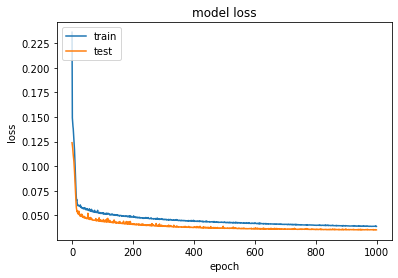

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

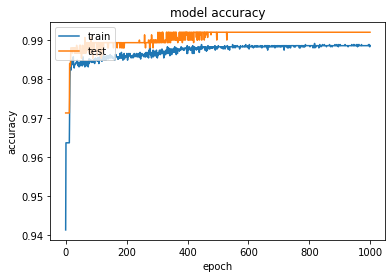

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
keras.backend.clear_session()